In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
import os
import urllib
import urllib.request
import gzip
import struct
import time

In [ ]:
class mnist_helper:

    def __init__(self):
        self.train_lbl, self.train_img, self.test_lbl, self.test_img = self.load_mnist_data()

    def get_data(self):
        return self.train_lbl, self.train_img, self.test_lbl, self.test_img

    @staticmethod
    def download_data(url, force_download=False):
        fname = url.split("/")[-1]
        if force_download or not os.path.exists(fname):
            urllib.request.urlretrieve(url, fname)
        return fname

    def load_data(self, label_url, image_url, force_download=False):
        with gzip.open(self.download_data(label_url, force_download)) as flbl:
            struct.unpack(">II", flbl.read(8))
            label = np.fromstring(flbl.read(), dtype=np.int8)
        with gzip.open(self.download_data(image_url, force_download), 'rb') as fimg:
            magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
            image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
        return label, image

    def load_mnist_data(self):
        path = 'http://yann.lecun.com/exdb/mnist/'
        train_lbl, train_img = self.load_data(
            path + 'train-labels-idx1-ubyte.gz', path + 'train-images-idx3-ubyte.gz')
        test_lbl, test_img = self.load_data(
            path + 't10k-labels-idx1-ubyte.gz', path + 't10k-images-idx3-ubyte.gz')

        return self.to_one_hot(train_lbl), train_img, self.to_one_hot(test_lbl), test_img

    @staticmethod
    def to_one_hot(labels, num_classes=10):
        return np.eye(num_classes)[labels]

In [ ]:
def sigmoid_function(signal, derivative=False):
    if derivative:
        return np.multiply(signal, 1.0 - signal)
    else:
        return 1.0 / (1.0 + np.exp(-signal))

def subtract_err(outputs, targets):
    res = outputs - targets
    return res

In [ ]:

class LinearLayer:
    def __init__(self, name, n_in, n_out, activation=sigmoid_function):
        self.name = name
        self.activation = activation
        self.result = []

        self.weights = 2 * np.random.random((n_in, n_out)) - 1
        self.biases = np.zeros(n_out)

    def get_output(self, x):
        result = self.activation(x.dot(self.weights) + self.biases)
        self.result = result
        return result


class SparseLayer(LinearLayer):
    def __init__(self, name, n_in, n_out, activation=sigmoid_function, num_k_sparse=10):
        LinearLayer.__init__(self, name, n_in, n_out, activation)
        self.num_k_sparse = num_k_sparse

    def get_output(self, x):
        result = self.activation(x.dot(self.weights) + self.biases)

        k = self.num_k_sparse
        if k < result.shape[1]:
            for raw in result:
                indices = np.argpartition(raw, -k)[-k:]
                mask = np.ones(raw.shape, dtype=bool)
                mask[indices] = False
                raw[mask] = 0

        self.result = result
        return result

In [ ]:
    def costAE(self, theta, visible_input):
        W1, W2, b1, b2 = self.unpack_theta(theta)
        
        hidden_layer = self.sigmoid(np.dot(W1, visible_input) + b1)
        output_layer = self.sigmoid(np.dot(W2, hidden_layer) + b2)
        m = visible_input.shape[1] 
        
        error = -(visible_input - output_layer)
        sum_sq_error =  0.5 * np.sum(error * error, axis = 0)
        avg_sum_sq_error = np.mean(sum_sq_error)
        reg_cost =  self.lambda_ * (np.sum(W1 * W1) + np.sum(W2 * W2)) / 2.0
        rho_bar = np.mean(hidden_layer, axis=1)
        KL_div = np.sum(self.rho * np.log(self.rho / rho_bar) + 
                        (1 - self.rho) * np.log((1-self.rho) / (1- rho_bar)))        
        cost = avg_sum_sq_error + reg_cost + self.beta * KL_div
        
        # Back propagation
        KL_div_grad = self.beta * (- self.rho / rho_bar + (1 - self.rho) / 
                                    (1 - rho_bar))
        
        del_3 = error * output_layer * (1.0 - output_layer)
        del_2 = np.transpose(W2).dot(del_3) + KL_div_grad[:, np.newaxis]
        del_2 *= hidden_layer * (1 - hidden_layer)
               
        W1_grad = del_2.dot(visible_input.transpose()) / m
        W2_grad = del_3.dot(hidden_layer.transpose()) / m
        b1_grad = del_2
        b2_grad = del_3
        
        W1_grad += self.lambda_ * W1 
        W2_grad += self.lambda_ * W2
        b1_grad = b1_grad.mean(axis = 1)
        b2_grad = b2_grad.mean(axis = 1)
        
        theta_grad = np.concatenate((W1_grad.flatten(), W2_grad.flatten(), 
                                     b1_grad.flatten(), b2_grad.flatten()))        
        return [cost, theta_grad]

In [ ]:
# fcnn

class FCNeuralNet:
    def __init__(self, layers, cost_func=subtract_err):
        self.layers = layers
        self.cost_func = cost_func

    def print_network(self):
        print("network:")
        for layer in self.layers:
            print("layer - %s: weights: %s" % (layer.name, layer.weights.shape))

    def train(self, x, y, learning_rate=0.01, epochs=10000,
              batch_size=256, print_epochs=1000,
              monitor_train_accuracy=False):
        # print("training start")
        start_time = time.time()

        for k in range(epochs):
            rand_indices = np.random.randint(x.shape[0], size=batch_size)
            batch_x = x[rand_indices]
            batch_y = y[rand_indices]

            results = self.feed_forward(batch_x)

            error = self.cost_func(results[-1], batch_y)

            if (k+1) % print_epochs == 0:
                loss = np.mean(np.abs(error))
                msg = "epochs: {0}, loss: {1:.4f}".format((k+1), loss)
                if monitor_train_accuracy:
                    accuracy = self.accuracy(x, y)
                    msg += ", accuracy: {0:.2f}%".format(accuracy)
                # print(msg)
            deltas = self.back_propagate(results, error)
            self.update_weights(results, deltas, learning_rate)

        end_time = time.time() - start_time
        elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time))
        # print("training complete, elapsed time:", elapsed_time)

    def feed_forward(self, x):
        results = [x]
        for i in range(len(self.layers)):
            output_result = self.layers[i].get_output(results[i])
            results.append(output_result)
        return results

    def back_propagate(self, results, error):
        last_layer = self.layers[-1]
        deltas = [error * last_layer.activation(results[-1], derivative=True)]
        for i in range(len(results) - 2, 0, -1):
            layer = self.layers[i]
            delta = deltas[-1].dot(layer.weights.T) * layer.activation(results[i], derivative=True)
            deltas.append(delta)

        deltas.reverse()
        return deltas

    def update_weights(self, results, deltas, learning_rate):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer_result = results[i]
            delta = deltas[i]
            layer.weights -= learning_rate * layer_result.T.dot(delta)
            # layer.biases += delta

    def predict(self, x):
        return self.feed_forward(x)[-1]

    def accuracy(self, x_data, y_labels):
        predictions = np.argmax(self.predict(x_data), axis=1)
        labels = np.argmax(y_labels, axis=1)
        accuracy = np.mean(predictions == labels)
        return accuracy * 100

Untitled Diagram.drawio.svg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


network:
layer - hidden 1: weights: (784, 200)
layer - hidden 2: weights: (200, 100)
layer - output: weights: (100, 784)


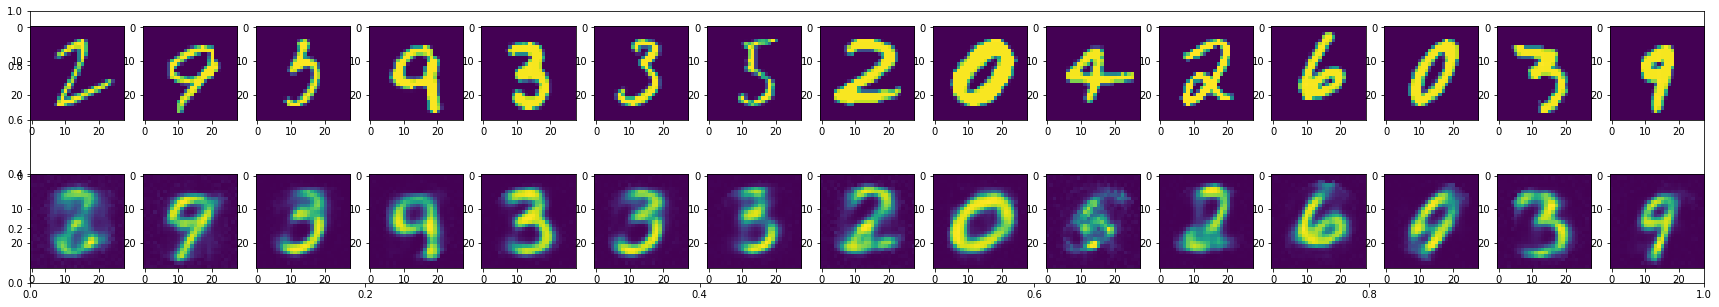

In [ ]:
def run_auto_encoder():
    img_size = 28
    num_hidden = 200
    k = 10
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 15

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / float(256)
    test_data = test_img.reshape(-1, img_size * img_size) / float(256)
    
    layers = [
        # LinearLayer(name="input", n_in=x_data.shape[1], n_out=num_hidden, activation=sigmoid_function),
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        SparseLayer(name="hidden 2", n_in=num_hidden, n_out=100,
                    activation=sigmoid_function, num_k_sparse=k),
        # SparseLayer(name="hidden 3", n_in=400, n_out=100,
        #             activation=sigmoid_function, num_k_sparse=k),
        # SparseLayer(name="hidden 4", n_in=100, n_out=300,
        #             activation=sigmoid_function, num_k_sparse=k),
        # LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
        LinearLayer(name="output", n_in=100, n_out=x_data.shape[1], activation=sigmoid_function)
    ]
    global nn
    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()


    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)
    n = num_test_examples

    test_samples = test_data[np.random.randint(test_data.shape[0], size=15)]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    global hidden_layer_op
    hidden_layer_op = nn.feed_forward(test_samples)
    global img_input
    global img_output
    global img_encode

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    global all_images
    all_images = np.concatenate((img_input, img_output))
    #                           test sample, o/p sample, encode sample
    
    add_plot_images(all_images, cols=15, img_size=img_size)
    plt.show()

def add_plot_images(images, cols=15, img_size=14, title=None):
    n_images = len(images)    
    fig = plt.figure(figsize=(30, 5))
    plt.title(title, fontsize=24)
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)

def main():
    run_auto_encoder()

main()

In [ ]:
c = mnist_helper()
x_data = c.train_img.reshape(-1, 28 * 28) / float(256) 
x_data_re = nn.predict(x_data)  
y_data = c.train_lbl 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


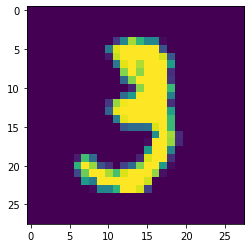

In [ ]:
plt.imshow(x_data[10].reshape((28,28)))

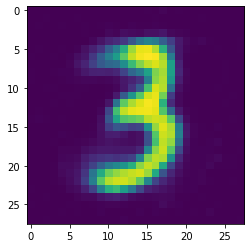

In [ ]:
plt.imshow(x_data_re[10].reshape((28,28)))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier      #classification on original data
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_data[500:], y_data[500:])
pred_op = neigh.predict(x_data[:500])
acco = np.all((pred_op == y_data[:500]), axis=1).sum() / pred_op.shape[0] * 100
print ('Accuracy on original: ', acco)

Accuracy on original:  96.2


In [ ]:
neigh.fit(x_data_re[500:], y_data[500:])                #classification on reconstructed data
pred_op = neigh.predict(x_data[:500])
accr = np.all((pred_op == y_data[:500]), axis=1).sum() / pred_op.shape[0] * 100
print ('Accuracy on reconstruted: ', accr)

Accuracy on reconstruted:  91.0


In [ ]:
cm = confusion_matrix(np.argmax(y_data[:500], axis=1), np.argmax(pred_op, axis=1))
cm

array([[50,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4, 62,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2, 46,  0,  0,  1,  0,  1,  0,  0],
       [ 4,  0,  0, 45,  0,  1,  0,  0,  0,  0],
       [ 2,  0,  0,  0, 48,  0,  0,  0,  0,  2],
       [ 2,  0,  0,  2,  0, 35,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 44,  0,  0,  0],
       [ 3,  0,  0,  0,  1,  0,  0, 48,  0,  0],
       [ 2,  0,  1,  1,  0,  1,  0,  0, 34,  0],
       [ 5,  0,  0,  1,  3,  0,  0,  2,  0, 44]])

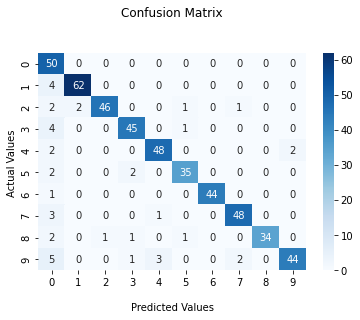

In [ ]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()